# Clasificación con data de cirugías cardíacas con CEC

In [305]:
import findspark
findspark.init()

In [306]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pysparkSeminario")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

In [307]:
spark.version

'2.4.5'

In [308]:
from pathlib import Path
import pandas as pd

In [309]:
def extract_bd_data(url, refresh_cache=False):
    cache_fn = Path('/dataset/BD_completa_4.csv')
    if not cache_fn.exists() or refresh_cache:
        print("Getting data")
        cec = pd.read_csv(url)
        cec.to_csv(cache_fn, index=False)
    print("Using cache")
    cec = spark.read.csv(str(cache_fn), header=True)
    return cec

In [310]:
url = 'https://github.com/CarlosLugones07/SEMINARIO/raw/main/BD_completa.csv'

In [311]:
cec_raw = extract_bd_data(url)

Using cache


In [312]:
type(cec_raw)

pyspark.sql.dataframe.DataFrame

In [313]:
cec_raw.show(5)

+---+----+---------+---+------+-----------------+--------------+---------+--------+-------+------+-----+
|SEX|EDAD|  CIRUGIA|FEY|BYPASS|BYPASS ARTERIALES|BYPASS VENOSOS|  VALVULA|POSICION|T CLAMP|T BOMB|HIPOT|
+---+----+---------+---+------+-----------------+--------------+---------+--------+-------+------+-----+
|  M|  80|COMBINADO| 63|   1.0|             null|           1.0|BIOLOGICO| AORTICO|     68|    86| LEVE|
|  F|  76|COMBINADO| 53|   1.0|             null|           1.0|BIOLOGICO| AORTICO|     60|    80| LEVE|
|  M|  75|COMBINADO| 66|   2.0|              1.0|           1.0|BIOLOGICO| AORTICO|     93|   102| LEVE|
|  F|  68|COMBINADO| 55|   1.0|              1.0|          null|BIOLOGICO| AORTICO|     50|    70| LEVE|
|  F|  65|COMBINADO| 65|   2.0|              1.0|           1.0|BIOLOGICO| AORTICO|     90|   102| LEVE|
+---+----+---------+---+------+-----------------+--------------+---------+--------+-------+------+-----+
only showing top 5 rows



In [314]:
cec_raw.printSchema()

root
 |-- SEX: string (nullable = true)
 |-- EDAD: string (nullable = true)
 |-- CIRUGIA: string (nullable = true)
 |-- FEY: string (nullable = true)
 |-- BYPASS: string (nullable = true)
 |-- BYPASS ARTERIALES: string (nullable = true)
 |-- BYPASS VENOSOS: string (nullable = true)
 |-- VALVULA: string (nullable = true)
 |-- POSICION: string (nullable = true)
 |-- T CLAMP: string (nullable = true)
 |-- T BOMB: string (nullable = true)
 |-- HIPOT: string (nullable = true)



In [315]:
from pyspark.sql.types import DoubleType, IntegerType

In [316]:
columns_to_convert = ['EDAD', 'FEY', 'BYPASS', 'BYPASS ARTERIALES', 'BYPASS VENOSOS', 'T CLAMP', 'T BOMB']

for col_name in columns_to_convert:
    cec_raw = cec_raw.withColumn(col_name, cec_raw[col_name].cast(IntegerType()))

In [317]:
cec_raw.printSchema()

root
 |-- SEX: string (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- CIRUGIA: string (nullable = true)
 |-- FEY: integer (nullable = true)
 |-- BYPASS: integer (nullable = true)
 |-- BYPASS ARTERIALES: integer (nullable = true)
 |-- BYPASS VENOSOS: integer (nullable = true)
 |-- VALVULA: string (nullable = true)
 |-- POSICION: string (nullable = true)
 |-- T CLAMP: integer (nullable = true)
 |-- T BOMB: integer (nullable = true)
 |-- HIPOT: string (nullable = true)



# Análisis exploratorio de los datos

In [318]:
cec_raw.groupBy('SEX').count().orderBy('count').show(10)

+---+-----+
|SEX|count|
+---+-----+
|  F|  163|
|  M|  569|
+---+-----+



In [319]:
cec_raw.groupBy('CIRUGIA').count().orderBy('count').show(30)

+--------------+-----+
|       CIRUGIA|count|
+--------------+-----+
|       CRM+CIA|    1|
| COMBINADO+RAA|    1|
|       CRM+RAA|    1|
|           CIV|    1|
|CRVAO+CRVM+RAA|    1|
|     CRVAO+RAA|    2|
|          CRVT|    2|
|       CRM+CIV|    3|
|   BENTALL+CRM|    7|
|           CIA|    9|
|           RAA|   17|
|       BENTALL|   19|
|    CRVAO+CRVM|   34|
|          CRVM|   47|
|     COMBINADO|   85|
|         CRVAO|  102|
|           CRM|  400|
+--------------+-----+



In [320]:
cec_raw.groupBy('POSICION').count().orderBy('count').show(30)

+--------------+-----+
|      POSICION|count|
+--------------+-----+
|   TRICUSPIDEO|    3|
|AORTICO+MITRAL|   38|
|        MITRAL|   60|
|       AORTICO|  199|
|          null|  432|
+--------------+-----+



In [321]:
cec_raw.groupBy('HIPOT').count().orderBy('count').show(10)

+-----------+-----+
|      HIPOT|count|
+-----------+-----+
|NORMOTERMIA|    5|
|   MODERADA|   13|
|   PROFUNDA|   26|
|       LEVE|  688|
+-----------+-----+



In [322]:
cec_raw.groupBy('VALVULA').count().orderBy('count').show(30)

+---------+-----+
|  VALVULA|count|
+---------+-----+
|BIOLOGICO|   84|
| MECANICO|  216|
|     null|  432|
+---------+-----+



In [323]:
cec_raw.count()

732

In [324]:
quantitative_columns = ["EDAD", "FEY", "T CLAMP", "T BOMB"]
cec_raw_quantitative = cec_raw.select(quantitative_columns)

In [325]:
summary = cec_raw_quantitative.describe()
summary.show()

+-------+------------------+-----------------+------------------+------------------+
|summary|              EDAD|              FEY|           T CLAMP|            T BOMB|
+-------+------------------+-----------------+------------------+------------------+
|  count|               732|              732|               732|               732|
|   mean| 61.17896174863388|45.88934426229508|61.830601092896174| 95.92349726775956|
| stddev|11.300615336860863|9.512899794327517| 25.42629687060247|32.032595314482194|
|    min|                17|               20|                 3|                20|
|    max|                88|               67|               165|               250|
+-------+------------------+-----------------+------------------+------------------+



In [326]:
import matplotlib.pyplot as plt

In [327]:
selected_cec_raw = cec_raw.select(*quantitative_columns)

In [328]:
# Convierte el DataFrame de PySpark a un DataFrame de Pandas para trazar los gráficos
pandas_cec_raw = selected_cec_raw.toPandas()

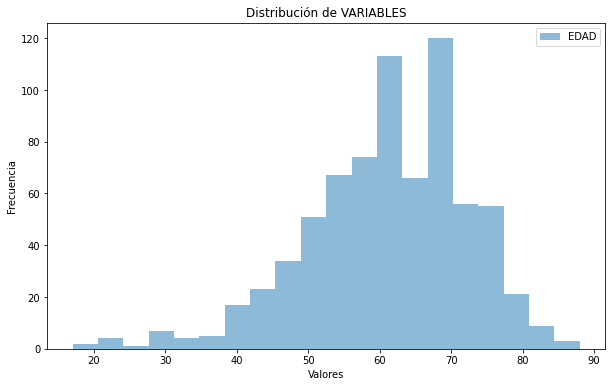

In [329]:
plt.figure(figsize=(10, 6))
plt.hist(pandas_cec_raw["EDAD"], bins=20, alpha=0.5, label="EDAD")
plt.legend()
plt.title("Distribución de VARIABLES")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

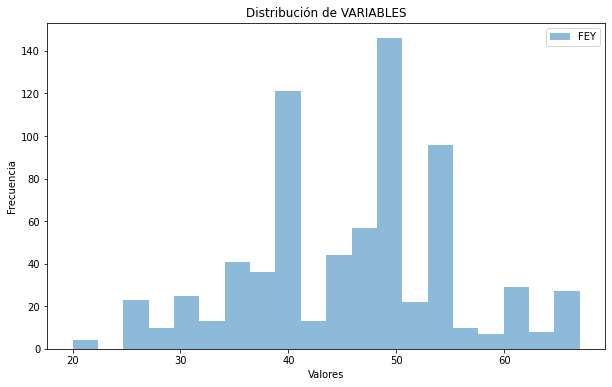

In [330]:
plt.figure(figsize=(10, 6))
plt.hist(pandas_cec_raw["FEY"], bins=20, alpha=0.5, label="FEY")
plt.legend()
plt.title("Distribución de VARIABLES")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

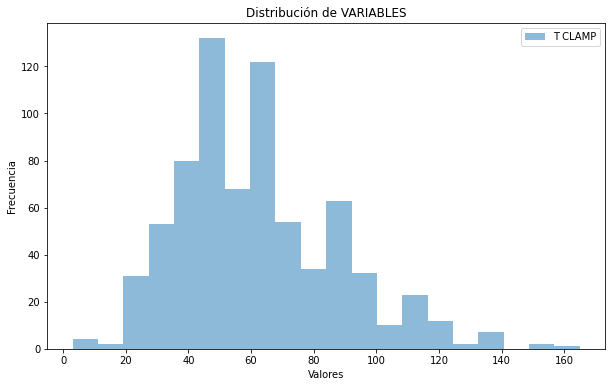

In [331]:
plt.figure(figsize=(10, 6))
plt.hist(pandas_cec_raw["T CLAMP"], bins=20, alpha=0.5, label="T CLAMP")
plt.legend()
plt.title("Distribución de VARIABLES")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

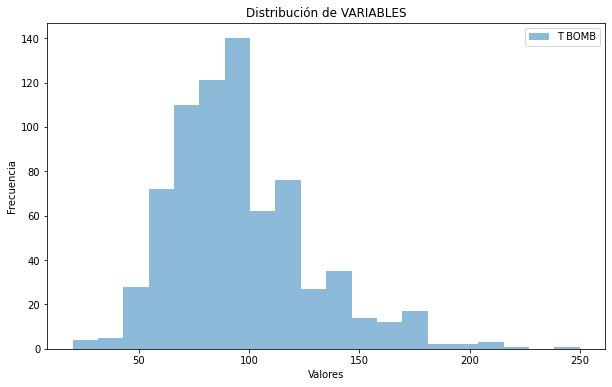

In [332]:
plt.figure(figsize=(10, 6))
plt.hist(pandas_cec_raw["T BOMB"], bins=20, alpha=0.5, label="T BOMB")
plt.legend()
plt.title("Distribución de VARIABLES")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

# Ingeniería de atributos

In [333]:
from pyspark.sql.functions import col

In [334]:
cec_raw = cec_raw.withColumn("DIFF", col("T BOMB") - col("T CLAMP"))

In [335]:
cec_raw.show(5)

+---+----+---------+---+------+-----------------+--------------+---------+--------+-------+------+-----+----+
|SEX|EDAD|  CIRUGIA|FEY|BYPASS|BYPASS ARTERIALES|BYPASS VENOSOS|  VALVULA|POSICION|T CLAMP|T BOMB|HIPOT|DIFF|
+---+----+---------+---+------+-----------------+--------------+---------+--------+-------+------+-----+----+
|  M|  80|COMBINADO| 63|     1|             null|             1|BIOLOGICO| AORTICO|     68|    86| LEVE|  18|
|  F|  76|COMBINADO| 53|     1|             null|             1|BIOLOGICO| AORTICO|     60|    80| LEVE|  20|
|  M|  75|COMBINADO| 66|     2|                1|             1|BIOLOGICO| AORTICO|     93|   102| LEVE|   9|
|  F|  68|COMBINADO| 55|     1|                1|          null|BIOLOGICO| AORTICO|     50|    70| LEVE|  20|
|  F|  65|COMBINADO| 65|     2|                1|             1|BIOLOGICO| AORTICO|     90|   102| LEVE|  12|
+---+----+---------+---+------+-----------------+--------------+---------+--------+-------+------+-----+----+
only showi

In [336]:
diff_pd = cec_raw.select("DIFF").toPandas()

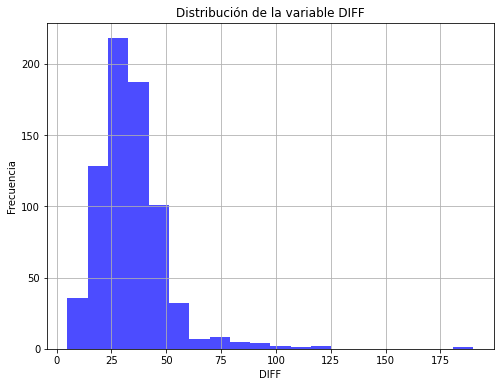

In [337]:
plt.figure(figsize=(8, 6))
plt.hist(diff_pd["DIFF"], bins=20, color='blue', alpha=0.7)
plt.title('Distribución de la variable DIFF')
plt.xlabel('DIFF')
plt.ylabel('Frecuencia')
plt.grid(True)

In [338]:
import seaborn as sns
import matplotlib.pyplot as plt

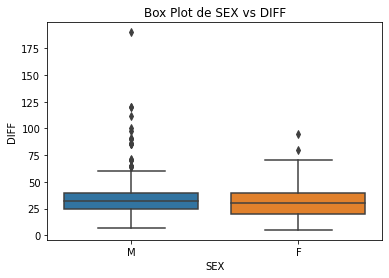

In [339]:
sns.boxplot(data=cec_raw.toPandas(), x="SEX", y="DIFF")
plt.title("Box Plot de SEX vs DIFF")
plt.show()

In [340]:
# Calcular el resumen de medias
dfSEX = cec_raw.select("SEX", "DIFF")
meansSEX = dfSEX.groupBy("SEX").mean("DIFF")
meansSEX = meansSEX.withColumnRenamed("avg(DIFF)", "mean_DIFF")
meansSEX.show()

+---+------------------+
|SEX|         mean_DIFF|
+---+------------------+
|  M|34.746924428822496|
|  F|31.809815950920246|
+---+------------------+



In [341]:
from pyspark.sql.functions import col
from scipy import stats

In [342]:
dataSEX = cec_raw.withColumn("SEX", col("SEX").cast("string"))

In [343]:
data_M = dataSEX.filter(dataSEX.SEX == "M").select("DIFF")
data_F = dataSEX.filter(dataSEX.SEX == "F").select("DIFF")

In [344]:
DIFF_M = data_M.rdd.flatMap(lambda x: x).collect()
DIFF_F = data_F.rdd.flatMap(lambda x: x).collect()

In [345]:
# Realizar el análisis ANOVA
f_statistic, p_value = stats.f_oneway(DIFF_M, DIFF_F)

print("Estadística F:", f_statistic)
print("Valor p:", p_value)

Estadística F: 4.150945560167308
Valor p: 0.041971434503442484


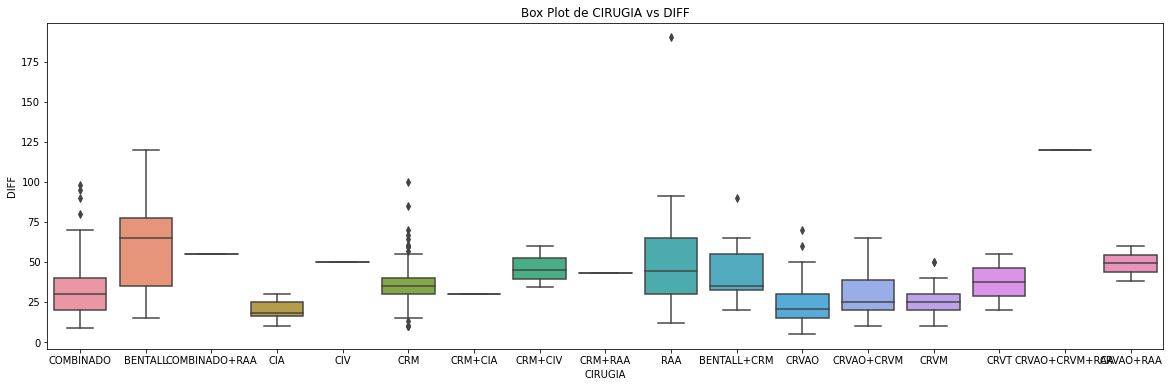

In [346]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=cec_raw.toPandas(), x="CIRUGIA", y="DIFF")
plt.title("Box Plot de CIRUGIA vs DIFF")
plt.show()

In [347]:
dfCIRUGIA = cec_raw.select("CIRUGIA", "DIFF")
meansCIRUGIA = dfCIRUGIA.groupBy("CIRUGIA").mean("DIFF")
meansCIRUGIA = meansCIRUGIA.withColumnRenamed("avg(DIFF)", "mean_DIFF")
meansCIRUGIA.orderBy('mean_DIFF').show(20)

+--------------+------------------+
|       CIRUGIA|         mean_DIFF|
+--------------+------------------+
|           CIA| 20.11111111111111|
|         CRVAO| 23.50980392156863|
|          CRVM|25.319148936170212|
|       CRM+CIA|              30.0|
|    CRVAO+CRVM|30.029411764705884|
|     COMBINADO| 33.71764705882353|
|           CRM|           35.8275|
|          CRVT|              37.5|
|       CRM+RAA|              43.0|
|   BENTALL+CRM|45.714285714285715|
|       CRM+CIV|46.333333333333336|
|     CRVAO+RAA|              49.0|
|           CIV|              50.0|
|           RAA|54.588235294117645|
| COMBINADO+RAA|              55.0|
|       BENTALL|58.473684210526315|
|CRVAO+CRVM+RAA|             120.0|
+--------------+------------------+



In [348]:
from pyspark.sql.functions import col
from scipy import stats

In [349]:
data = cec_raw.withColumn("CIRUGIA", col("CIRUGIA").cast("string"))

In [350]:
data_1 = data.filter(data.CIRUGIA == "CIA").select("DIFF")
data_2 = data.filter(data.CIRUGIA == "CRVAO").select("DIFF")
data_3 = data.filter(data.CIRUGIA == "CRVM").select("DIFF")
data_4 = data.filter(data.CIRUGIA == "CRM+CIA").select("DIFF")
data_5 = data.filter(data.CIRUGIA == "CRVAO+CRVM").select("DIFF")
data_6 = data.filter(data.CIRUGIA == "COMBINADO").select("DIFF")
data_7 = data.filter(data.CIRUGIA == "CRM").select("DIFF")
data_8 = data.filter(data.CIRUGIA == "CRVT").select("DIFF")
data_9 = data.filter(data.CIRUGIA == "CRM+RAA").select("DIFF")
data_10 = data.filter(data.CIRUGIA == "BENTALL+CRM").select("DIFF")
data_11 = data.filter(data.CIRUGIA == "CRVAO+RAA").select("DIFF")
data_12 = data.filter(data.CIRUGIA == "CRM+CIV").select("DIFF")
data_13 = data.filter(data.CIRUGIA == "CIV").select("DIFF")
data_14 = data.filter(data.CIRUGIA == "RAA").select("DIFF")
data_15 = data.filter(data.CIRUGIA == "COMBINADO+RAA").select("DIFF")
data_16 = data.filter(data.CIRUGIA == "BENTALL").select("DIFF")
data_17 = data.filter(data.CIRUGIA == "CRVAO+CRVM+RAA").select("DIFF")

In [351]:
# Extraer los tiempos de bombeo como listas de Python
DIFF_1 = data_1.rdd.flatMap(lambda x: x).collect()
DIFF_2 = data_2.rdd.flatMap(lambda x: x).collect()
DIFF_3 = data_3.rdd.flatMap(lambda x: x).collect()
DIFF_4 = data_4.rdd.flatMap(lambda x: x).collect()
DIFF_5 = data_5.rdd.flatMap(lambda x: x).collect()
DIFF_6 = data_6.rdd.flatMap(lambda x: x).collect()
DIFF_7 = data_7.rdd.flatMap(lambda x: x).collect()
DIFF_8 = data_8.rdd.flatMap(lambda x: x).collect()
DIFF_9 = data_9.rdd.flatMap(lambda x: x).collect()
DIFF_10 = data_10.rdd.flatMap(lambda x: x).collect()
DIFF_11 = data_11.rdd.flatMap(lambda x: x).collect()
DIFF_12 = data_12.rdd.flatMap(lambda x: x).collect()
DIFF_13 = data_13.rdd.flatMap(lambda x: x).collect()
DIFF_14 = data_14.rdd.flatMap(lambda x: x).collect()
DIFF_15 = data_15.rdd.flatMap(lambda x: x).collect()
DIFF_16 = data_16.rdd.flatMap(lambda x: x).collect()
DIFF_17 = data_17.rdd.flatMap(lambda x: x).collect()

In [352]:
# Realizar el análisis ANOVA
f_statistic, p_value = stats.f_oneway(DIFF_1, DIFF_2, DIFF_3, DIFF_4, DIFF_5, DIFF_6, DIFF_7, DIFF_8, DIFF_9, DIFF_10, DIFF_11, DIFF_12, DIFF_13, DIFF_14, DIFF_15, DIFF_16, DIFF_17)

print("Estadística F:", f_statistic)
print("Valor p:", p_value)

Estadística F: 14.371758430810438
Valor p: 4.373589338418125e-34


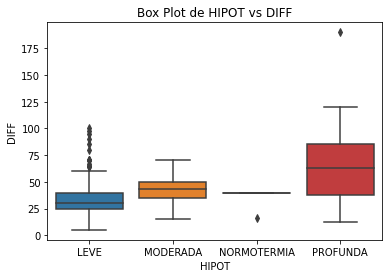

In [353]:
sns.boxplot(data=cec_raw.toPandas(), x="HIPOT", y="DIFF")
plt.title("Box Plot de HIPOT vs DIFF")
plt.show()

In [354]:
dfHIPOT = cec_raw.select("HIPOT", "DIFF")
meansHIPOT = dfHIPOT.groupBy("HIPOT").mean("DIFF")
meansHIPOT = meansHIPOT.withColumnRenamed("avg(DIFF)", "mean_DIFF")
meansHIPOT.orderBy('mean_DIFF').show()

+-----------+-----------------+
|      HIPOT|        mean_DIFF|
+-----------+-----------------+
|       LEVE|32.63226744186046|
|NORMOTERMIA|             35.2|
|   MODERADA|43.07692307692308|
|   PROFUNDA|68.03846153846153|
+-----------+-----------------+



In [355]:
from pyspark.sql.functions import col
from scipy import stats

In [356]:
data = cec_raw.withColumn("HIPOT", col("HIPOT").cast("string"))

In [357]:
data_Mo = data.filter(data.HIPOT == "MODERADA").select("DIFF")
data_Le = data.filter(data.HIPOT == "LEVE").select("DIFF")
data_Nor = data.filter(data.HIPOT == "NORMOTERMIA").select("DIFF")
data_Pr = data.filter(data.HIPOT == "PROFUNDA").select("DIFF")


In [358]:
DIFF_MO = data_Mo.rdd.flatMap(lambda x: x).collect()
DIFF_LE = data_Le.rdd.flatMap(lambda x: x).collect()
DIFF_NOR = data_Nor.rdd.flatMap(lambda x: x).collect()
DIFF_PR = data_Pr.rdd.flatMap(lambda x: x).collect()


In [359]:
# Realizar el análisis ANOVA
f_statistic, p_value = stats.f_oneway(DIFF_MO, DIFF_LE, DIFF_NOR, DIFF_PR)

print("Estadística F:", f_statistic)
print("Valor p:", p_value)

Estadística F: 49.01088092584098
Valor p: 7.380014696733004e-29


In [361]:
# Filtrar columnas sin valores nulos
columnas_sin_nulos = [col_name for col_name in cec_raw.columns if cec_raw.filter(col(col_name).isNotNull()).count() == cec_raw.count()]
cec_nonull = cec_raw.select(*columnas_sin_nulos)

In [362]:
cec_nonull.show(5)

+---+----+---------+---+-------+------+-----+----+
|SEX|EDAD|  CIRUGIA|FEY|T CLAMP|T BOMB|HIPOT|DIFF|
+---+----+---------+---+-------+------+-----+----+
|  M|  80|COMBINADO| 63|     68|    86| LEVE|  18|
|  F|  76|COMBINADO| 53|     60|    80| LEVE|  20|
|  M|  75|COMBINADO| 66|     93|   102| LEVE|   9|
|  F|  68|COMBINADO| 55|     50|    70| LEVE|  20|
|  F|  65|COMBINADO| 65|     90|   102| LEVE|  12|
+---+----+---------+---+-------+------+-----+----+
only showing top 5 rows



In [363]:
cec_nonull.printSchema()

root
 |-- SEX: string (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- CIRUGIA: string (nullable = true)
 |-- FEY: integer (nullable = true)
 |-- T CLAMP: integer (nullable = true)
 |-- T BOMB: integer (nullable = true)
 |-- HIPOT: string (nullable = true)
 |-- DIFF: integer (nullable = true)



# Correlaciones bivariadas

In [364]:
from pyspark.sql.functions import corr

In [365]:
correlation_fey = cec_nonull.corr("DIFF", "FEY")
correlation_edad = cec_nonull.corr("DIFF", "EDAD")

In [366]:
print(f"Correlación entre DIFF y FEY: {correlation_fey}")
print(f"Correlación entre DIFF y EDAD: {correlation_edad}")

Correlación entre DIFF y FEY: -0.7714855622584246
Correlación entre DIFF y EDAD: 0.05044664693055381


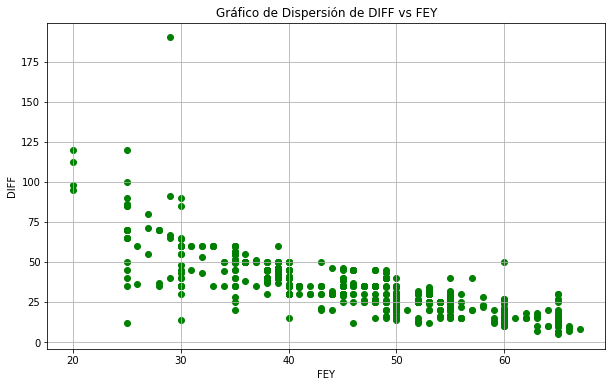

In [367]:
df_diff_fey = cec_nonull.select("DIFF", "FEY")
df_diff_fey_pd = df_diff_fey.toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(df_diff_fey_pd["FEY"], df_diff_fey_pd["DIFF"], c='g')
plt.xlabel('FEY')
plt.ylabel('DIFF')
plt.title('Gráfico de Dispersión de DIFF vs FEY')
plt.grid(True)
plt.show()

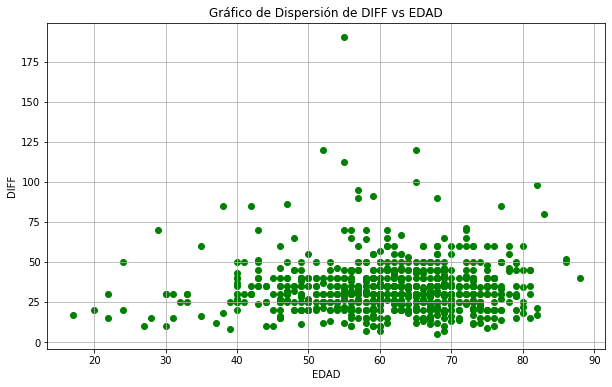

In [368]:
df_diff_edad = cec_nonull.select("DIFF", "EDAD")
df_diff_edad_pd = df_diff_edad.toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(df_diff_edad_pd["EDAD"], df_diff_edad_pd["DIFF"], c='g')
plt.xlabel('EDAD')
plt.ylabel('DIFF')
plt.title('Gráfico de Dispersión de DIFF vs EDAD')
plt.grid(True)
plt.show()

# Indexar variables categóricas

In [369]:
from pyspark.ml.feature import StringIndexer

In [370]:
indexer_sex = StringIndexer(inputCol="SEX", outputCol="SEX_indexed")
indexer_cirugia = StringIndexer(inputCol="CIRUGIA", outputCol="CIRUGIA_indexed")
indexer_hipot = StringIndexer(inputCol="HIPOT", outputCol="HIPOT_indexed")

In [371]:
cec_nonull = indexer_sex.fit(cec_nonull).transform(cec_nonull)
cec_nonull = indexer_cirugia.fit(cec_nonull).transform(cec_nonull)
cec_nonull = indexer_hipot.fit(cec_nonull).transform(cec_nonull)

In [372]:
cec_nonull.show(5)

+---+----+---------+---+-------+------+-----+----+-----------+---------------+-------------+
|SEX|EDAD|  CIRUGIA|FEY|T CLAMP|T BOMB|HIPOT|DIFF|SEX_indexed|CIRUGIA_indexed|HIPOT_indexed|
+---+----+---------+---+-------+------+-----+----+-----------+---------------+-------------+
|  M|  80|COMBINADO| 63|     68|    86| LEVE|  18|        0.0|            2.0|          0.0|
|  F|  76|COMBINADO| 53|     60|    80| LEVE|  20|        1.0|            2.0|          0.0|
|  M|  75|COMBINADO| 66|     93|   102| LEVE|   9|        0.0|            2.0|          0.0|
|  F|  68|COMBINADO| 55|     50|    70| LEVE|  20|        1.0|            2.0|          0.0|
|  F|  65|COMBINADO| 65|     90|   102| LEVE|  12|        1.0|            2.0|          0.0|
+---+----+---------+---+-------+------+-----+----+-----------+---------------+-------------+
only showing top 5 rows



In [373]:
cec_nonull.printSchema()

root
 |-- SEX: string (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- CIRUGIA: string (nullable = true)
 |-- FEY: integer (nullable = true)
 |-- T CLAMP: integer (nullable = true)
 |-- T BOMB: integer (nullable = true)
 |-- HIPOT: string (nullable = true)
 |-- DIFF: integer (nullable = true)
 |-- SEX_indexed: double (nullable = false)
 |-- CIRUGIA_indexed: double (nullable = false)
 |-- HIPOT_indexed: double (nullable = false)



In [374]:
columns_to_convert2 = ['SEX_indexed', 'CIRUGIA_indexed', 'HIPOT_indexed']

for col_name in columns_to_convert2:
    cec_nonull = cec_nonull.withColumn(col_name, cec_nonull[col_name].cast(IntegerType()))

In [375]:
cec_nonull.printSchema()

root
 |-- SEX: string (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- CIRUGIA: string (nullable = true)
 |-- FEY: integer (nullable = true)
 |-- T CLAMP: integer (nullable = true)
 |-- T BOMB: integer (nullable = true)
 |-- HIPOT: string (nullable = true)
 |-- DIFF: integer (nullable = true)
 |-- SEX_indexed: integer (nullable = true)
 |-- CIRUGIA_indexed: integer (nullable = true)
 |-- HIPOT_indexed: integer (nullable = true)



In [376]:
cec_nonull.show(5)

+---+----+---------+---+-------+------+-----+----+-----------+---------------+-------------+
|SEX|EDAD|  CIRUGIA|FEY|T CLAMP|T BOMB|HIPOT|DIFF|SEX_indexed|CIRUGIA_indexed|HIPOT_indexed|
+---+----+---------+---+-------+------+-----+----+-----------+---------------+-------------+
|  M|  80|COMBINADO| 63|     68|    86| LEVE|  18|          0|              2|            0|
|  F|  76|COMBINADO| 53|     60|    80| LEVE|  20|          1|              2|            0|
|  M|  75|COMBINADO| 66|     93|   102| LEVE|   9|          0|              2|            0|
|  F|  68|COMBINADO| 55|     50|    70| LEVE|  20|          1|              2|            0|
|  F|  65|COMBINADO| 65|     90|   102| LEVE|  12|          1|              2|            0|
+---+----+---------+---+-------+------+-----+----+-----------+---------------+-------------+
only showing top 5 rows



In [377]:
from pyspark.ml.feature import VectorAssembler

In [378]:
feature_cols = ["EDAD","FEY","SEX_indexed","CIRUGIA_indexed","HIPOT_indexed"]

In [379]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [380]:
cec_nonullIN = assembler.transform(cec_nonull)

In [381]:
cec_nonullIN.show(5)

+---+----+---------+---+-------+------+-----+----+-----------+---------------+-------------+--------------------+
|SEX|EDAD|  CIRUGIA|FEY|T CLAMP|T BOMB|HIPOT|DIFF|SEX_indexed|CIRUGIA_indexed|HIPOT_indexed|            features|
+---+----+---------+---+-------+------+-----+----+-----------+---------------+-------------+--------------------+
|  M|  80|COMBINADO| 63|     68|    86| LEVE|  18|          0|              2|            0|[80.0,63.0,0.0,2....|
|  F|  76|COMBINADO| 53|     60|    80| LEVE|  20|          1|              2|            0|[76.0,53.0,1.0,2....|
|  M|  75|COMBINADO| 66|     93|   102| LEVE|   9|          0|              2|            0|[75.0,66.0,0.0,2....|
|  F|  68|COMBINADO| 55|     50|    70| LEVE|  20|          1|              2|            0|[68.0,55.0,1.0,2....|
|  F|  65|COMBINADO| 65|     90|   102| LEVE|  12|          1|              2|            0|[65.0,65.0,1.0,2....|
+---+----+---------+---+-------+------+-----+----+-----------+---------------+----------

# Definición de muestra de entrenamiento y testeo

In [382]:
train_cec, test_cec = cec_nonullIN.randomSplit([0.7,0.3],seed=191123)

In [383]:
train_cec.count()

511

In [384]:
train_cec.show(5)

+---+----+----------+---+-------+------+-----------+----+-----------+---------------+-------------+--------------------+
|SEX|EDAD|   CIRUGIA|FEY|T CLAMP|T BOMB|      HIPOT|DIFF|SEX_indexed|CIRUGIA_indexed|HIPOT_indexed|            features|
+---+----+----------+---+-------+------+-----------+----+-----------+---------------+-------------+--------------------+
|  F|  17|       CIA| 65|     10|    27|       LEVE|  17|          1|              7|            0|[17.0,65.0,1.0,7....|
|  F|  24|      CRVM| 34|     70|   120|       LEVE|  50|          1|              3|            0|[24.0,34.0,1.0,3....|
|  F|  32|     CRVAO| 53|     80|   105|       LEVE|  25|          1|              1|            0|[32.0,53.0,1.0,1....|
|  F|  35|       CIA| 60|     14|    30|NORMOTERMIA|  16|          1|              7|            3|[35.0,60.0,1.0,7....|
|  F|  35|CRVAO+CRVM| 30|     60|   120|       LEVE|  60|          1|              4|            0|[35.0,30.0,1.0,4....|
+---+----+----------+---+-------

In [385]:
test_cec.count()

221

In [386]:
test_cec.show(5)

+---+----+-----------+---+-------+------+-----+----+-----------+---------------+-------------+--------------------+
|SEX|EDAD|    CIRUGIA|FEY|T CLAMP|T BOMB|HIPOT|DIFF|SEX_indexed|CIRUGIA_indexed|HIPOT_indexed|            features|
+---+----+-----------+---+-------+------+-----+----+-----------+---------------+-------------+--------------------+
|  F|  30|        CIA| 65|     30|    60| LEVE|  30|          1|              7|            0|[30.0,65.0,1.0,7....|
|  F|  30|      CRVAO| 44|     80|   110| LEVE|  30|          1|              1|            0|[30.0,44.0,1.0,1....|
|  F|  31|        CIA| 65|     30|    45| LEVE|  15|          1|              7|            0|[31.0,65.0,1.0,7....|
|  F|  40|BENTALL+CRM| 30|     90|   125| LEVE|  35|          1|              8|            0|[40.0,30.0,1.0,8....|
|  F|  43|    BENTALL| 25|     80|   150| LEVE|  70|          1|              5|            0|[43.0,25.0,1.0,5....|
+---+----+-----------+---+-------+------+-----+----+-----------+--------

# Regresión lineal

In [387]:
from pyspark.ml.regression import LinearRegression

In [388]:
lr = LinearRegression(featuresCol="features", labelCol="DIFF")

In [389]:
model = lr.fit(train_cec)

In [390]:
predictions = model.transform(test_cec)

In [392]:
predictions.select("DIFF", "prediction").show(20)

+----+------------------+
|DIFF|        prediction|
+----+------------------+
|  30| 7.369846143307711|
|  30|33.737390802274284|
|  15| 7.379831854119374|
|  35|51.812255549088135|
|  70|  58.0635360004124|
|  50| 38.89474572937439|
|  15|11.110965413316876|
|  25|21.330252583571436|
|  30|22.497962332840345|
|  40|27.571547324084023|
|  25| 23.88202364541077|
|  40|62.187285438429925|
|  25|26.325618925599358|
|  25|23.901995067034107|
|  35| 38.99460283749107|
|  40| 51.76177682022188|
|  35| 35.21687479879039|
|  20|26.509796144380374|
|  20| 26.47373755049678|
|  20|  27.9920475277899|
+----+------------------+
only showing top 20 rows



In [393]:
type(predictions)

pyspark.sql.dataframe.DataFrame

In [394]:
from pyspark.ml.evaluation import RegressionEvaluator

In [395]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="DIFF",predictionCol="prediction")

In [396]:
rmse = evaluator.evaluate(predictions)

In [397]:
print(f"Error cuadrático medio (RMSE): {rmse}")

Error cuadrático medio (RMSE): 8.728391569352608


In [398]:
from pyspark.sql.functions import col, var_pop

In [399]:
# Calcula la varianza total de la columna "DIFF"
varianza_total = predictions.select(var_pop(col("DIFF"))).collect()[0][0]

In [400]:
# Calcula R²
r_cuadrado = 1 - (rmse**2 / varianza_total)

In [401]:
print(f"Coeficiente de Determinación (R²): {r_cuadrado}")

Coeficiente de Determinación (R²): 0.7110672224578491


In [402]:
import matplotlib.pyplot as plt
import numpy as np

In [403]:
predictions = predictions.select("DIFF", "prediction").toPandas()

In [404]:
y_true = predictions["DIFF"]
y_pred = predictions["prediction"]

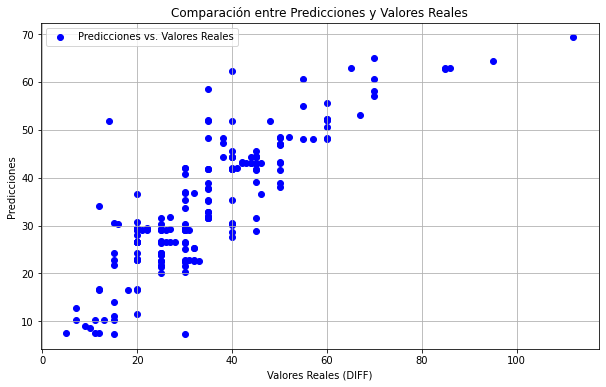

In [405]:
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, c='b', label='Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales (DIFF)')
plt.ylabel('Predicciones')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.grid(True)
plt.show()

In [406]:
import seaborn as sns

In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [408]:
# Calcular los residuos
predictions['residuos'] = predictions['DIFF'] - predictions['prediction']
predictions


,DIFF,prediction,residuos
0,30,7.369846,22.630154
1,30,33.737391,-3.737391
2,15,7.379832,7.620168
3,35,51.812256,-16.812256
4,70,58.063536,11.936464
...,...,...,...
216,55,60.691398,-5.691398
217,15,21.793057,-6.793057
218,60,52.148580,7.851420
219,50,48.482912,1.517088


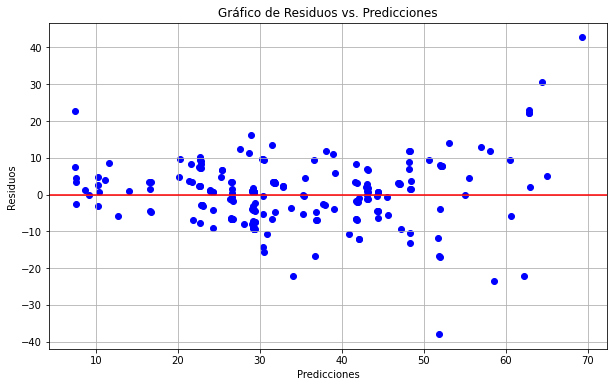

In [409]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions['prediction'], predictions['residuos'], c='b')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Predicciones')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.show()



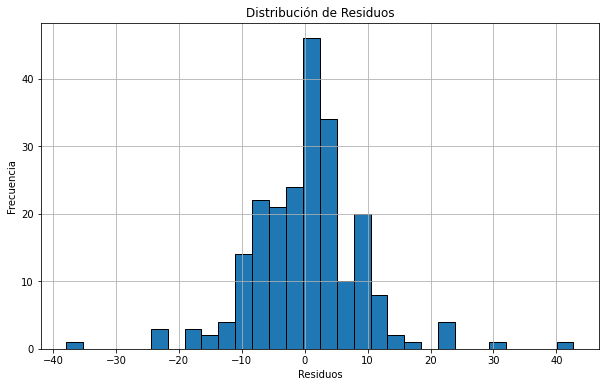

In [410]:
plt.figure(figsize=(10, 6))
plt.hist(predictions['residuos'], bins=30, edgecolor='k')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')
plt.grid(True)
plt.show()



In [411]:
# Prueba de normalidad de los residuos
from scipy.stats import shapiro
shapiro_test = shapiro(predictions['residuos'])
print("Prueba de normalidad de los residuos (W-statistic, p-value):", shapiro_test)



Prueba de normalidad de los residuos (W-statistic, p-value): (0.9441724419593811, 1.6701258687135123e-07)


In [ ]:
spark.stop()